## Initiailization

In [0]:
%load_ext autoreload
%autoreload 2

import torch

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import math
import random
import os
from scipy import ndimage

In [3]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'deep-cube'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
#sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/My Drive/{}/src'.format(FOLDERNAME))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/deep-cube/src

/content/drive/My Drive/deep-cube/src


In [5]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
t, c, a

(17071734784, 0, 0)

In [0]:
from model_lcrn import LRCN
from model_seq_cnn import SequentialCNN
from model_trainer import train_model
from data_loader import VideoDataset
import data_utils
from pprint import pprint
import data_def
import metrics

In [0]:
from util import *

In [8]:
print(torch.cuda.is_available())
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_SAVE_PATH = os.path.realpath(
    os.path.join(
        os.path.abspath(''),
        '..', 'saved_models'
    )
)

True


## Preparation
We initialize our custom dataloader. It will return a new sample clip drawn uniformly from all possible clips of L frames from all the videos.


In [9]:
from data_loader import *
B, L, C = 20, 100, data_utils.NUM_CHANNEL
train_dataset, train_loader = get_train_data(B, L)
dev_dataset, dev_loader = get_dev_data(B, L)
H, W = train_dataset.frame_size()

VideoDataset __init__
clip_length: 100
frame size: 68 x 90
video files:
['kevin_random_moves_quick.mp4',
 'kevin_random_moves_quick_2.mp4',
 'kevin_random_moves_quick_3.mp4',
 'kevin_random_moves_quick_4.mp4',
 'kevin_rotate_1.mp4',
 'kevin_simple_shuffle_1.mp4',
 'kevin_single_moves_2.mp4',
 'kevin_single_solve_1.mp4',
 'kevin_solve_play_1.mp4',
 'kevin_solve_play_10.mp4',
 'kevin_solve_play_11.mp4',
 'kevin_solve_play_12.mp4',
 'kevin_solve_play_13.mp4',
 'kevin_solve_play_2.mp4',
 'kevin_solve_play_3.mp4',
 'kevin_solve_play_7.mp4',
 'kevin_solve_play_8.mp4',
 'kevin_solve_play_9.mp4',
 'russell_scramble0.mp4',
 'russell_scramble1.mp4',
 'russell_scramble3.mp4',
 'russell_scramble4.mp4',
 'russell_scramble5.mp4',
 'russell_scramble7.mp4',
 'russell_stable0.mp4',
 'russell_stable1.mp4',
 'russell_stable2.mp4',
 'russell_stable3.mp4',
 'zhouheng_cfop_solve.mp4',
 'zhouheng_long_solve_1.mp4',
 'zhouheng_long_solve_2.mp4',
 'zhouheng_long_solve_3.mp4',
 'zhouheng_oll_algorithm.mp4',
 'z

Now let's display the frames from a random sample:

(100, 3, 68, 90) (array([ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0, 12,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,
       15,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0,  0,  0,  0,  0,
        0, 13, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,
        0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0],
      dtype=uint8), array([ 2,  2, 12, 12, 15, 13, 13, 14, 12, 15, 13, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
      dtype=uint8), 11)


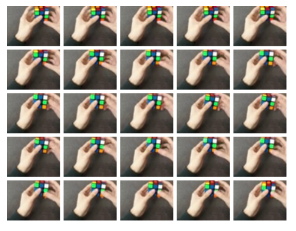

In [10]:
sample = train_dataset[0]
print(sample[0].shape, sample[1:])
show_video(sample[0], end=25)

In [0]:
#train_dataset.debug(True)
# import time
# start_time = time.time()
# for i in range(50):
#   train_dataset[0]
# print("--- Generating 50 samples took %s seconds ---" % (time.time() - start_time))

## 3dConv Model

Let's load our trained model first. 
The best three models are:
- Conv3_spatial_augment
- LRCN3d_spatial_augment
- LRCN_deep_spatial_augment


In [12]:
from model_trainer import train_model, load_trained
import model_lrcn
from train_utils import load_model_save
from eval_resnet import MODEL_INFO_KEYS

# our best model so far: 
model_desc = [
    ("conv3d", 'conv_spatial_augment'),
    ('lrcn','lrcn_deep_spatial_augment'),
    ('lrcn3d', 'lrcn3d_spatial_augment' ),
    ('res3d', 'resnet3d_layer50_min_7_random_crop')
]
models = dict()
for (model_name, model_filename) in model_desc:
  if model_name == 'res3d':
    models[model_name], results = load_model_save(model_filename, load_best=True)
    print(model_name, models[model_name])
    for key in results:
      if type(results[key]) == list:
        r = results[key][-1] if len(results[key]) > 0 else None
      else:
        r = results[key]
      print(f'{key}:', r)
  else:
    models[model_name], results = load_trained(model_filename)
    print(model_name, models[model_name], results)
    max_dev_idx = len(next(iter(results.values()))) - 1
    for key in results:
      if type(results[key]) == list:
        r = results[key][-1] if len(results[key]) > 0 else None
      else:
        r = results[key]
      print(f'{key}:', r)


  


conv3d ConvPredictor(
  (conv_module): SequentialCNN3DFrontTimePad(
    (module): Sequential(
      (0): ConstantPad3d(padding=(0, 0, 0, 0, 3, 1), value=0)
      (1): Conv3d(3, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
      (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Dropout(p=0.1, inplace=False)
      (5): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): ConstantPad3d(padding=(0, 0, 0, 0, 3, 1), value=0)
      (7): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
      (8): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): Dropout(p=0.1, inplace=False)
      (11): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): ConstantPad3d(padding=(0, 0, 0, 0, 3, 1), val

In [14]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
t, c, a

(17071734784, 541065216, 534371328)

## Visualization - Saliency over entire clip

To understand what part of the video is being picked up by CNN, we will generate the saliency map: We perform gradient ascent on the entire clip, and we try to answer two questions:
1. Is it the hand region or the cube region that is used by our network to recognize actions? Does the active regions differ by the layers? 

2. Do the frames with high saliency overlap with the active frames (i.e those surrounding the non-zero labels), and if not, why ?

In [0]:
# from train_conv.py
def compute_saliency_map(model, data, per_frame=False, name=None):

  x, y = data[0], data[1]
  print(x.shape)

  x = x.to(device=DEVICE, dtype=torch.float32)  # (B, L, C, H, W)
  y = y.to(device=DEVICE, dtype=torch.long)  # (B, L)
  
  model.eval()
  if name in ['lrcn','lrcn3d']:
    model.train()

  x.requires_grad_()
  assert(x.grad is None)
  scores = model(x)
  print(scores.shape)

  segment = name in ['res3d']

  if segment:
    loss = scores.max(1)[0].sum()
    loss.backward()
    saliency = torch.max(torch.abs(x.grad), 1)[0].cpu().numpy()
  elif not per_frame:
    loss = scores.max(2)[0].sum()
    loss.backward()
    #ctcloss = metrics.ctc_loss_sum(scores, y_collapsed, y_collapsed_l)
    #ctcloss.backward()
    # We take the loss over the score of the predicted class.
    saliency = torch.max(torch.abs(x.grad), 2)[0].cpu().numpy()
  else:
    loss_all = scores.max(2)[0]
    print(loss_all.shape)
    saliency = []
    for i in range(L):
      if x.grad is not None:
        x.grad.zero_()

      loss = loss_all[:, i].sum()
      loss.backward(retain_graph=True)
      with torch.no_grad():
        saliency.append( torch.max(torch.abs(x.grad), 2)[0].cpu().numpy() )
    saliency = np.array(saliency)

    print(saliency.shape, data.shape, scores.shape)

  del x
  del y
  return saliency, data, scores.detach().cpu().numpy()


In [0]:
def get_dev_data_with_name(B, L, filenames, verbose_init=True):
    dev_dataset = VideoDataset(
        DEFAULT_VIDEO_PATH,
        DEFAULT_LABEL_PATH,
        clip_length=L,
        verbose_init=verbose_init,
        video_filenames=filenames
    )
    dev_loader = torch.utils.data.DataLoader(
        dev_dataset, batch_size=B, num_workers=DATALOADER_NUM_WORKERS,
    )
    return dev_dataset, dev_loader

In [23]:
DEV_FILENAMES = [
    'kevin_single_moves_1.mp4',
    'kevin_solve_play_6.mp4',
    'zhouheng_scramble_02.mp4',
    'russell_scramble2.mp4',
]
dev_loader_zhouheng = get_dev_data_with_name(B, L, DEV_FILENAMES)[1]

import data_loader
MIN_ACC_FRAME = 5
regular_rounds = 1
_, res3d_loader = data_loader.get_segmented_eval_data(MIN_ACC_FRAME)

rounds = { name : regular_rounds for name in models }
rounds['res3d'] = 10

data_list = []
for i in range(regular_rounds):
  data_list.append(next(iter(dev_loader_zhouheng)))

saliency_result = dict()
for (name, model) in models.items():
  saliency_all, sal_data, scores = [], [], []

  for i in range(rounds[name]):
    data = next(iter(res3d_loader)) if name == 'res3d' else data_list[i]
    saliency_all_curr, sal_data_curr, scores_curr = compute_saliency_map(model, data, name=name)
    saliency_all.append(saliency_all_curr)
    sal_data.append(sal_data_curr)
    scores.append(scores_curr)

  saliency_all = np.concatenate(saliency_all)
  scores = np.concatenate(scores)

  videos, labels = [], []
  for data in sal_data:
    x_c, y_c = data[:2]
    videos.append(x_c)
    labels.append(y_c)
  videos = np.concatenate(videos)
  labels = np.concatenate(labels)
  saliency_result[name] = saliency_all, scores, videos, labels

saliency_norm_once_flag = True

VideoDataset __init__
clip_length: 100
frame size: 68 x 90
video files:
['kevin_single_moves_1.mp4',
 'kevin_solve_play_6.mp4',
 'zhouheng_scramble_02.mp4',
 'russell_scramble2.mp4']

Getting TEST data...
min_accepted_frames: 5
frame size: (10, 68, 90, 3)
num_clips: 2336
apply_spatial_transform: False
apply_temporal_shift: False
torch.Size([20, 100, 3, 68, 90])
torch.Size([20, 100, 22])
torch.Size([20, 100, 3, 68, 90])
torch.Size([20, 100, 22])
torch.Size([20, 100, 3, 68, 90])
torch.Size([20, 100, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([5, 22])
torch.Size([5, 3, 5, 68, 90])
torch.Size([

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:


sa, sc,videos, la = saliency_result['res3d']
saliency_result['res3d'] = (sa, sc, videos.transpose( (0, 2, 1, 3, 4)), la)

for r in saliency_result['res3d']:
  print(r.shape)

(50, 5, 68, 90)
(50, 22)
(50, 5, 3, 68, 90)
(50,)


In [25]:
print(saliency_result['res3d'][1])

[[-13.852733    -3.4446945    1.3893412  ...  -0.31842887  -7.6104574
   -3.8070722 ]
 [ -9.692697     0.09990445   2.042043   ...  -3.8037612   -3.9110606
   -3.875159  ]
 [ -8.784293    -0.8330635    1.829628   ...  -4.244612    -4.8406563
   -3.900418  ]
 ...
 [-10.04779     -3.3930569    1.1588463  ...  -4.3336725   -4.4069743
   -3.923999  ]
 [ -8.044534    -2.4886503   -1.0585936  ...  -2.1822536   -2.7655468
   -3.1673033 ]
 [ -6.7430415   -1.9399344    1.660907   ...  -3.6492653   -2.654519
   -2.8728013 ]]


Mounted at /content/drive


In [0]:
#print(len(saliency_all))
if saliency_norm_once_flag:
  for name, result in saliency_result.items():
    saliency_all, scores, videos, labels = result
    for i in range(len(saliency_all)):
      sa = saliency_all[i]
      saliency_all[i] = 255 * (sa - np.min(sa))/np.ptp(sa)
  saliency_norm_once_flag = False


In [27]:

once = True
i = 1
for (name, result) in saliency_result.items():
  saliency_all, scores, videos, labels = result


  print("===== Video and Label =====")
  plt.figure(figsize=(20, 10))
  plt.title(f"{name} Video")
  videolen = videos[i].shape[0]
  if name == 'res3d':
    label = np.zeros((videolen), dtype='int')
    label[0] = labels[i]
  else:
    label = labels[i]
    
  show_video(videos[i], end=videolen, label=label)

  print(name, labels[i])
    
  #print("===== Model {} =====".format(name))

  #plt.figure()
  #plt.yscale("log")
  #plt.hist(saliency_all[0].flatten(), bins=20)
  plt.figure(figsize=(15, 15))
  plt.title(f"{name} Heatmap")

  if name == 'res3d':
    pred_ = np.argmax(scores[i])
    pred = np.zeros((videos[i].shape[0]), dtype='int')

    print(videos[i].shape)
    pred[0] = pred_

  else:
    pred = np.argmax(scores[i], axis=1)

  show_video_heatmap(saliency_all[i], start=0, end=videolen, label=pred)




Output hidden; open in https://colab.research.google.com to view.

In [0]:
def show_move_saliency(saliency_dict):

  def normalize(sa):
      sa = 255 * (sa - np.min(sa))/np.ptp(sa)
      sa[sa <10] = 0
      sa[sa < 100] *= 0.4
      return sa

  ks = sorted(list(saliency_dict.keys()))
  for k in ks:
    #print("Typical heatmap for k = {}, {}".format(k, CLASS_STRS[k]))
    n_samples_per_move = 4
    
    # sort by max_confidence
    samples = sorted(saliency_dict[k], key=lambda r: r[3] )[-n_samples_per_move:]
    for (video_idx, frames, pred_label, max_confidence) in samples:
      print("from video ", video_idx, "frames ", frames)
      
      fig = plt.figure(figsize=(50, 10))
      print("Saliency map for k = {}, {}, confidence = {}".format(k, CLASS_STRS[k], max_confidence))
      
      plt.subplot(2, 1, 1)
      plt.title("Saliency map for action {}, confidence = {:.3f}".format(CLASS_STRS[k], max_confidence), fontsize=40)

      lax = 5
      a1 = max(0, frames[0] - lax)
      a2 = min(len(saliency_all[video_idx]), frames[-1] + 1 )
      aug_frames = np.arange(a1, a2)
      frames = aug_frames

      saliency_sample = saliency_all[video_idx][frames]

      saliency_sample = normalize(saliency_sample)
      show_video_heatmap(saliency_sample, layout='row')

      plt.subplot(2, 1, 2)
      show_video(videos[video_idx][frames], layout='row')

      plt.show()

      #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)



# print("active_frames ", np.arange(100)[active_mask], "pred ", pred[active_mask], "label ", labels[0][active_mask])
# active_frames_saliency = saliency_video[active_mask]
# active_frames_orig = orig_video[active_mask]

# for (s, v) in zip(active_frames_saliency, active_frames_orig):
#   plt.figure()
#   plt.subplot(1, 2, 1)
#   plt.axis('off')
#   plt.imshow(s.astype('uint8'), vmin=0, vmax=255, cmap=plt.cm.hot)
#   plt.subplot(1, 2, 2)  
#   plt.axis('off')
#   plt.imshow(bgr_2_rgb(v.transpose((1, 2, 0))))

In [110]:
from data_def import CLASS_STRS
from collections import defaultdict
import scipy

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


def gather_res3d_segment(scores, labels, saliencys, videos, video_idx, saliency_dict, thresh=2):
  pred = scores[video_idx].argmax()
  ps = np.exp(scores[video_idx]) 
  ps /= np.sum(ps)
  max_confidence =  np.max(ps)
  if len(saliency_dict[pred]) >= thresh:
    return saliency_dict
  print(videos[video_idx].shape)
  saliency_dict[pred].append( (video_idx, range(videos[video_idx].shape[0]), \
                                pred, max_confidence) )
  return saliency_dict

def gather_segments(scores, labels, saliencys, videos, video_idx, saliency_dict, thresh=2):
  # explore the first clip
  pred = scores[video_idx].argmax(1)

  ps = np.exp(scores[video_idx])
  ps /= np.sum(ps, axis=1).reshape(-1, 1)
  ps = np.max(ps, axis=1)

  active_mask = pred > 0

  #print("active_frames ", np.arange(100)[active_mask], "pred ", pred[active_mask], "label ", labels[0][active_mask])
  #active_frames_saliency = saliencys[video_idx][active_mask]
  #active_frames_orig = videos[video_idx][active_mask]
  active_frames = np.arange(100)[active_mask]

  active_frame_segments = consecutive(active_frames)
  if len(active_frame_segments) == 0 or len(active_frame_segments[0]) == 0:
    return saliency_dict

  for frames in active_frame_segments:
    pred_label = pred[frames[0]]
    max_confidence = ps[frames[0]].max()
    if len(saliency_dict[pred_label]) >= thresh:
      continue

    if len(frames) == 0:
      continue
    lax = 4
    a1 = max(0, frames[0] - lax)
    a2 = min(len(labels[video_idx]), frames[-1] + 1 + lax )
    aug_frames = np.arange(a1, a2)
    labelset = set(labels[video_idx][aug_frames])


    if pred_label not in labelset:
      continue
    saliency_dict[pred_label].append( (video_idx, frames, pred_label, max_confidence) )

  return saliency_dict




for (name, result) in saliency_result.items():
  if name not in ['conv3d']: continue;
  print("===== Model {} =====".format(name))
  saliency_dict = defaultdict(list)

  saliency_all, scores, videos, labels = result
  for i in range(len(videos)):
    if name in ['res3d']:
      gather_res3d_segment(scores, labels, saliency_all, videos, i, saliency_dict, thresh=10)

    else:
      gather_segments(scores, labels, saliency_all, videos, i, saliency_dict, thresh=10)

  print(saliency_dict) 
  print( [ (CLASS_STRS[k], len(saliency_dict[k])) for k in saliency_dict ] )
  show_move_saliency(saliency_dict)
  

Output hidden; open in https://colab.research.google.com to view.

from video  0 frames  [27 28]
Typical heatmap for k = 14, U


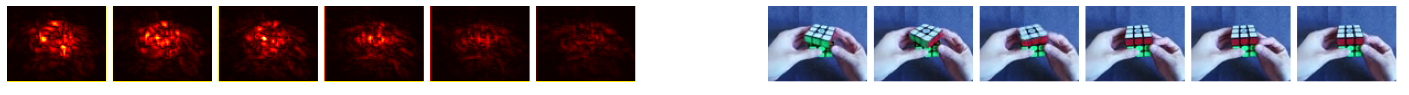

from video  0 frames  [79 80]
Typical heatmap for k = 15, U'


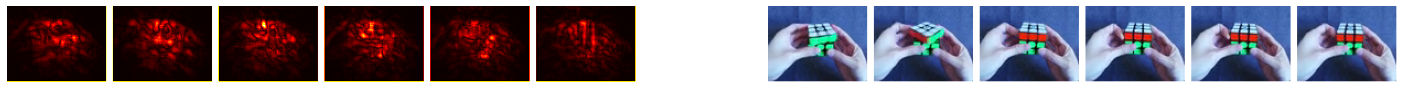

from video  2 frames  [83 84 85]
Typical heatmap for k = 12, R


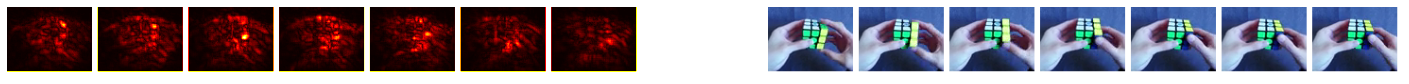

from video  3 frames  [27 28]
Typical heatmap for k = 13, R'


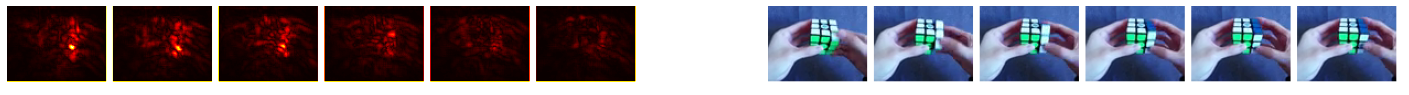

from video  4 frames  [93 94]
Typical heatmap for k = 11, L'


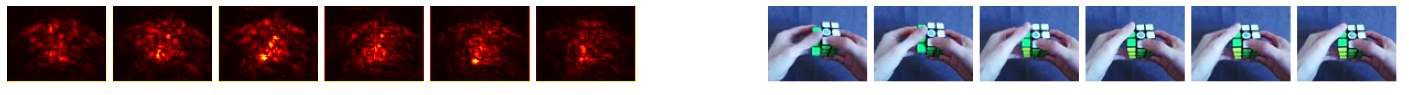

from video  6 frames  [26 27]
Typical heatmap for k = 10, L


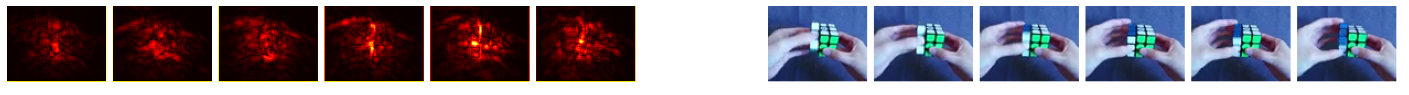

from video  8 frames  [70 71]
Typical heatmap for k = 18, F


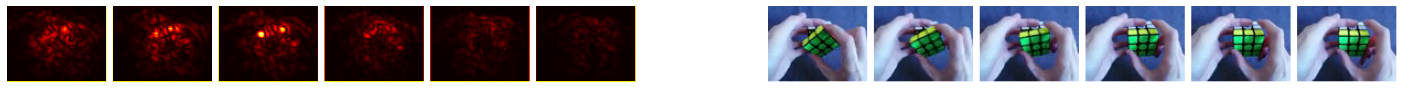

from video  9 frames  [43 44]
Typical heatmap for k = 19, F'


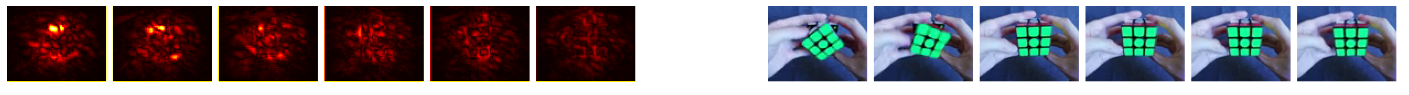

from video  11 frames  [44 45]
Typical heatmap for k = 20, B


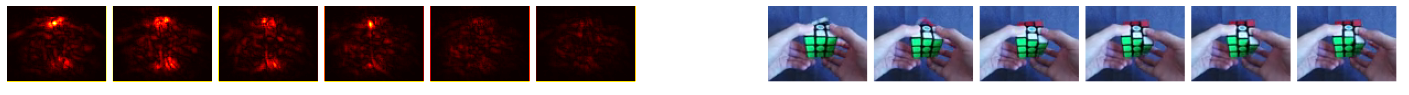

from video  12 frames  [43 44 45]
Typical heatmap for k = 21, B'


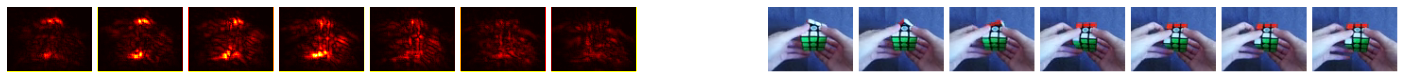

from video  13 frames  [78 79]
Typical heatmap for k = 17, D'


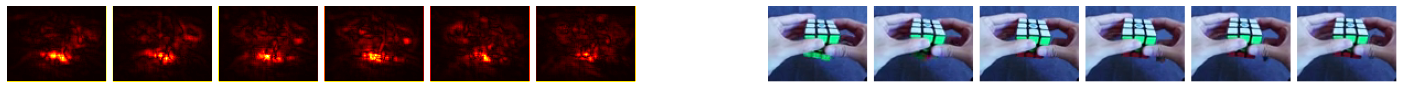

from video  14 frames  [19]
Typical heatmap for k = 16, D


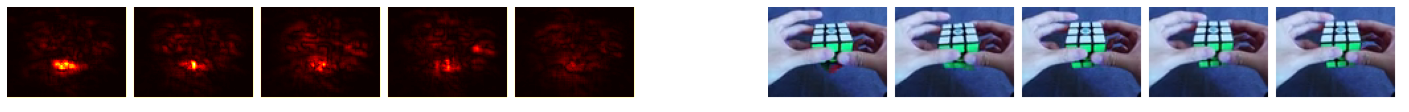

In [0]:

score = scores[0].argmax(1)
active_mask = score > 0
print("active_frames ", np.arange(100)[active_mask], "labels ", score[active_mask] )
active_frames_saliency = saliency_video[active_mask]
active_frames_orig = orig_video[active_mask]


active_frames  [25 26 27 38 39 40 50 51 63 64 78 79 90 91] labels  [14 14 14 14 14 14 14 14 14 14 15 15 15 15]


## Visualization - Frame by frame Saliency


Since our 3dCNN is convolving with filters over time, it simulates a moving window. The temporal-wise perceptive field is small (spanning ~17 frames) but it should be fine for our cube actions, which are quick actions spanning a few frames. So we should expect to see that the output at a given frame should mostly only take data from nearby frames, forming a diagonal line in the heatmap matrix. Let's confirm it with the frame by frame visualization below.


In [0]:
###
# from train_conv.py
def compute_saliency_map(model, data, per_frame=False, name=None):

  x, y = data[0], data[1]
  print(x.shape)

  x = x.to(device=DEVICE, dtype=torch.float32)  # (B, L, C, H, W)
  y = y.to(device=DEVICE, dtype=torch.long)  # (B, L)
  
  model.eval()
  if name in ['lrcn','lrcn3d']:
    model.train()

  x.requires_grad_()
  assert(x.grad is None)
  scores = model(x)
  print(scores.shape)

  segment = name in ['res3d']

  if segment:
    loss = scores.max(1)[0].sum()
    loss.backward()
    saliency = torch.max(torch.abs(x.grad), 1)[0]
  elif not per_frame:
    loss = scores.max(2)[0].sum()
    loss.backward()
    #ctcloss = metrics.ctc_loss_sum(scores, y_collapsed, y_collapsed_l)
    #ctcloss.backward()
    # We take the loss over the score of the predicted class.
    saliency = torch.max(torch.abs(x.grad), 2)[0]
  else:
    loss_all = scores.max(2)[0]
    print(loss_all.shape)
    saliency = []
    for i in range(L):
      if x.grad is not None:
        x.grad.zero_()

      loss = loss_all[:, i].sum()
      loss.backward(retain_graph=True)
      with torch.no_grad():
        saliency.append( torch.max(torch.abs(x.grad), 2)[0].cpu().numpy() )
    saliency = np.array(saliency)

    #print(saliency.shape, x.shape, scores.shape)

  return saliency, data, scores


In [61]:
def show_frame_by_frame_saliency():
  #DEV_FILENAMES
  dev_loader_zhouheng = get_dev_data_with_name(1, L, DEV_FILENAMES)[1]

  saliency_all, sal_data, scores = [], [], []
  ROUNDS = 1

  data = (next(iter(dev_loader_zhouheng)))
  result = {}

  for (name, model) in models.items():
    if name in ['res3d']: continue
    saliency_all, sal_data, scores = \
      compute_saliency_map(model, data, per_frame=True, name=name)

    # scores = scores.cpu().detach().numpy()

    # videos, labels = [], []
    # for data in sal_data:
    #   x_c, y_c, yc_c, ycl_c = data
    #   videos.append(x_c)
    #   labels.append(y_c)
    # videos = torch.cat(videos).cpu().numpy()
    # labels = torch.cat(labels).cpu().numpy()
    result[name] = saliency_all

  return result

results = show_frame_by_frame_saliency()


#saliency_all_fbf, scores_fbf, videos_fbf, labels_fbf = show_frame_by_frame_saliency()

VideoDataset __init__
clip_length: 100
frame size: 68 x 90
video files:
['kevin_single_moves_1.mp4',
 'kevin_solve_play_6.mp4',
 'zhouheng_scramble_02.mp4',
 'russell_scramble2.mp4']
torch.Size([1, 100, 3, 68, 90])
torch.Size([1, 100, 22])
torch.Size([1, 100])
torch.Size([1, 100, 3, 68, 90])
torch.Size([1, 100, 22])
torch.Size([1, 100])
torch.Size([1, 100, 3, 68, 90])
torch.Size([1, 100, 22])
torch.Size([1, 100])


In [62]:
results['lrcn3d'].shape

(100, 1, 100, 68, 90)

===== Model conv3d =====
(900, 68, 90) (100, 1, 100, 68, 90)
===== Model lrcn =====
(900, 68, 90) (100, 1, 100, 68, 90)
===== Model lrcn3d =====
(900, 68, 90) (100, 1, 100, 68, 90)


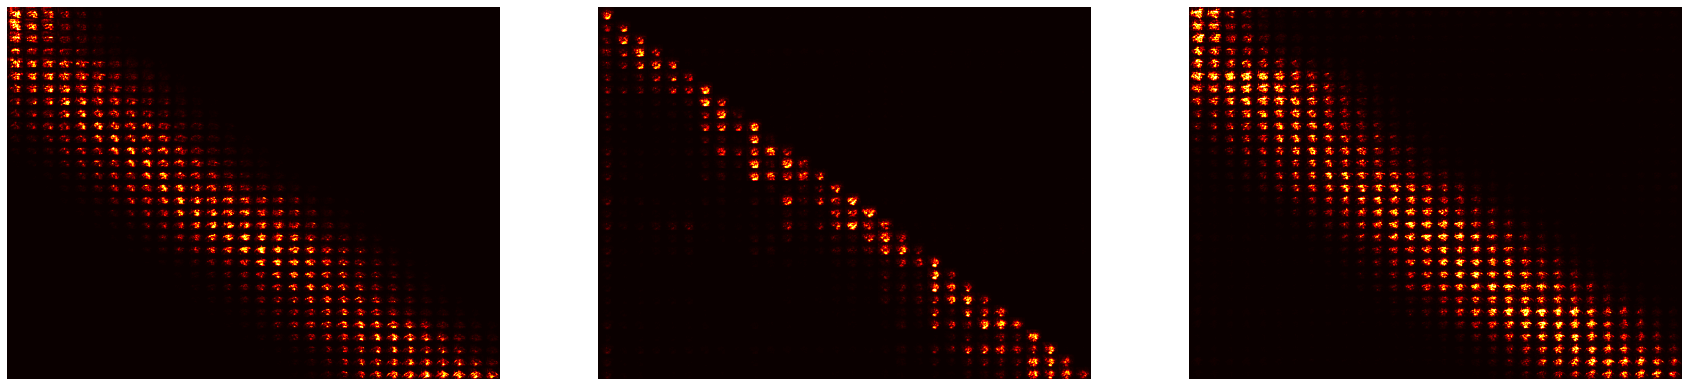

In [97]:
def normalize(sa):
    sa = 255 * (sa - np.min(sa))/np.ptp(sa)
    #sa[sa < 5] = 0
    sa[sa > 50] *= 3
    sa[sa > 20] *= 2
    sa[sa > 255] = 255
    return sa 

fig = plt.figure(figsize=(30, 10))
i = 1
fig.tight_layout()


for (name, saliency_all) in results.items():
    start, end = 0, 30
    img = np.concatenate( [normalize(saliency_all[i][0])[start:end] for i in range(start, end) ] )
    print("===== Model {} =====".format(name))

    print(img.shape, saliency_all.shape)
    plt.subplot(1, 3, i)
    show_video_heatmap(img, start=start, end=img.shape[0], layout='square', margin=0)
    i += 1


(900, 68, 90)


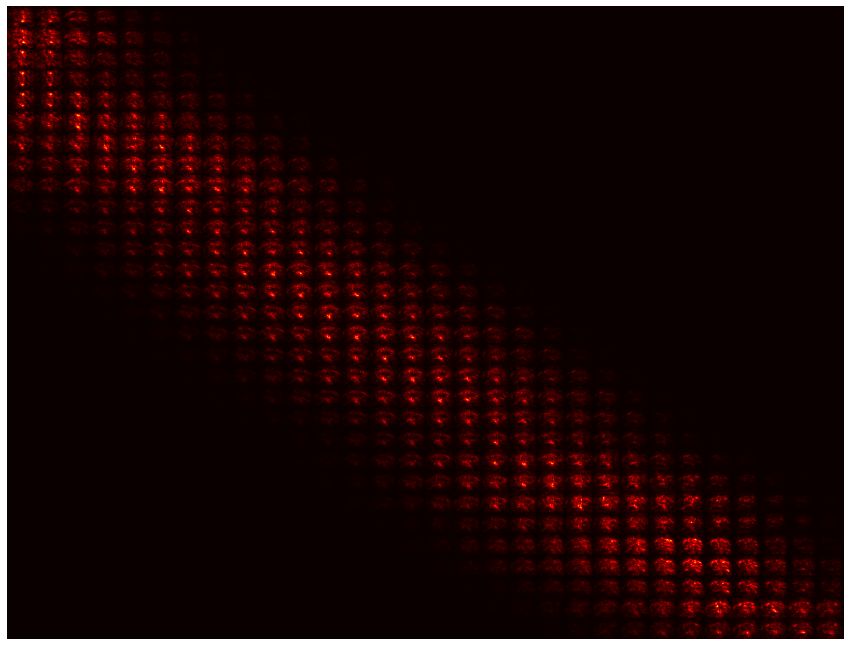

In [0]:

# start, end = 0, 30

# img = np.concatenate( [normalize(saliency_all_fbf[i][0])[start:end] for i in range(start, end) ] )
# print(img.shape)
# plt.figure(figsize=(15, 15))
# show_video_heatmap(img, start=start, end=img.shape[0], layout='square', margin=0)

## 